
Here we include the neural network model in PyMC3, utilizing Theano tensors to reconstruct the net.

In [346]:
%pylab inline
import pymc3 as pm
import os
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
a=ModelParameters()

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes', 'norm', 'figure', 'ndim', 'ma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [347]:
# Load in the neural network weights
model_numpy=np.load("/home/oliverphilcox/ChempyMulti/Jupyter/6element_neural_model.npz")
w_array_0=np.matrix(model_numpy["w_array_0"])
b_array_0=np.matrix(model_numpy["b_array_0"])
w_array_1=np.matrix(model_numpy["w_array_1"])
b_array_1=np.matrix(model_numpy["b_array_1"])
# Load standardization parameters
input_mean=model_numpy.f.input_mean
input_std=model_numpy.f.input_std
output_mean=model_numpy.f.output_mean
output_std=model_numpy.f.output_std

In [348]:
## Load in mock dataset
n_stars = 9 
apogee=np.load('/mnt/store1/oliverphilcox/APOGEE_Test/FullMockAPOGEE.npz') #dataset
mu_times = np.exp(apogee['ln_age'][:n_stars]) #age
sigma_times = mu_ages*apogee['ln_age_err'][:n_stars] #error on ln(age)

APOGEE_abundances=apogee['abun'][:n_stars]  #chemical element amounts for our data
APOGEE_errors=apogee['abun_err'][:n_stars]  #error on chemical elements from prexisting model

## USE CORRECT ELEMENTS

In [349]:
# Now standardize dataset
norm_data=(APOGEE_abundances[:,:6]-output_mean)/output_std # use only 6 elements
norm_sd = APOGEE_errors[:,:6]/output_std

In [350]:
data_obs = norm_data.ravel()
data_sd = np.asarray(norm_sd).ravel()

## Check these standardized widths work out right - should be same as std values?

In [351]:
# Define priors
Lambda_prior_mean = a.p0[:2]
Theta_prior_mean = a.p0[2:]
Lambda_prior_width = [0.3,0.3]
Theta_prior_width = [0.3,0.1,0.1]
# Now standardize
std_Lambda_prior_mean = (Lambda_prior_mean-input_mean[:2])/input_std[:2]
std_Lambda_prior_width = (Lambda_prior_width)/input_std[:2]
std_Theta_prior_mean = (Theta_prior_mean-input_mean[2:5])/input_std[2:5]
std_Theta_prior_width = (Theta_prior_width)/input_std[2:5]
std_times_mean = (mu_times-input_mean[-1])/input_std[-1]
std_times_width = sigma_times/input_std[-1]

# Define critical theta edge:
log_SFR_crit = 0.29402
std_log_SFR_crit = (log_SFR_crit-input_mean[3])/input_std[3]

# Define bounds on age to stop predicting out of parameter space:
min_time,max_time = [0.,13.5]
std_min_time,std_max_time=[(time-input_mean[-1])/input_std[-1] for time in [min_time,max_time]]

In [352]:
# Define stacked local priors
Local_prior_mean = np.vstack([np.hstack([std_Theta_prior_mean,std_times_mean[i]]) for i in range(n_stars)])
Local_prior_sigma = np.vstack([np.hstack([std_Theta_prior_width,std_times_width[i]]) for i in range(n_stars)])

In [353]:
import pymc3.math as ma
import theano.tensor as tt

# Share theano variables
w0=tt._shared(w_array_0)
b0=tt._shared(b_array_0)
w1=tt._shared(w_array_1)
b1=tt._shared(b_array_1)
ones_tensor = tt.ones([n_stars,1])

In [354]:
simple_model=pm.Model()
TruncatedNormal = pm.Bound(pm.Normal,lower=std_log_SFR_crit)
AgeNormal = pm.Bound(pm.Normal,lower=std_min_time,upper=std_max_time)

with simple_model:
    # Define priors
    Lambda = pm.Normal('Std-Lambda',mu=std_Lambda_prior_mean,sd=std_Lambda_prior_width,shape=(1,len(std_Lambda_prior_mean)))
    Theta1 = pm.Normal('Std-Theta1',mu=std_Theta_prior_mean[0],sd=std_Theta_prior_width[0],shape=(1,n_stars))
    Theta2 = TruncatedNormal('Std-Theta2',mu=std_Theta_prior_mean[1],sd=std_Theta_prior_width[1],shape=(1,n_stars))
    Theta3 = pm.Normal('Std-Theta3',mu=std_Theta_prior_mean[2],sd=std_Theta_prior_width[2],shape=(1,n_stars))
    Thetas = ma.concatenate([Theta1,Theta2,Theta3]).T
    #Thetas = pm.Normal('Std-Thetas',mu=std_Theta_prior_mean,sd=std_Theta_prior_width,shape=(n_stars,len(std_Theta_prior_mean)))
    Times = AgeNormal('Std-Times',mu=std_times_mean,sd=std_times_width,shape=(1,n_stars))
    
    TruLa = pm.Deterministic('Lambda',Lambda*input_std[:2]+input_mean[:2])
    TruTh = pm.Deterministic('Thetas',Thetas*input_std[2:5]+input_mean[2:5])
    TruTi = pm.Deterministic('Times',Times*input_std[-1]+input_mean[-1])
    
    # Define input parameter matrix
    Lambda_all = ma.matrix_dot(tt.ones([n_stars,1]),Lambda)
    InputVariables = ma.concatenate([Lambda_all,Thetas,Times.T],axis=1)
    
    # Define neural network output
    #Layer 1: (N_el,20) Tanh w0,b0
    #Output Layer: (20,N_el) w1,b1
    layer1 = ma.matrix_dot(InputVariables,w0.T)+ma.matrix_dot(ones_tensor,b0)
    output = ma.matrix_dot(ma.tanh(layer1),w1.T)+ma.matrix_dot(ones_tensor,b1)
    
    network_output = pm.Deterministic("Neural Network",output)
    
    # Define likelihood function (unravelling output to make a multivariate gaussian)
    pm.Normal('likelihood', mu=output.ravel(), sd=data_sd, observed=data_obs)

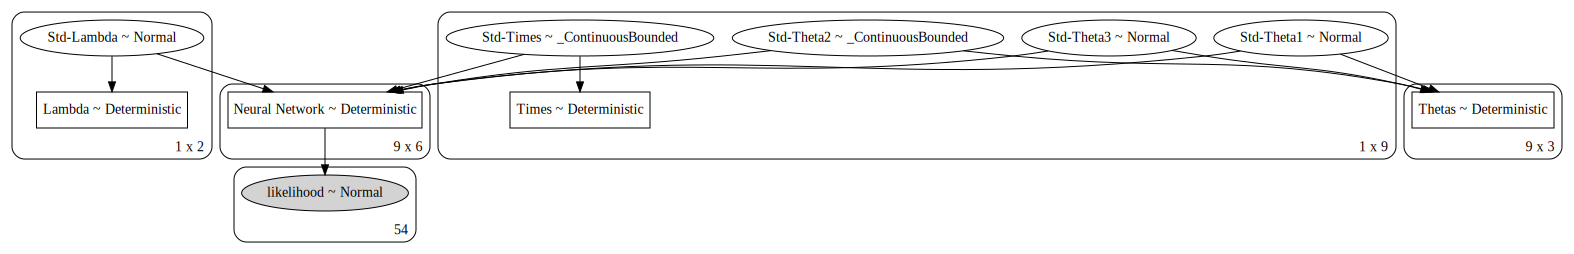

In [355]:
pm.model_to_graphviz(simple_model)

In [356]:
# Now sample
with simple_model:
    samples=pm.sample(draws=1000,chains=4,cores=4,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Std-Times, Std-Theta3, Std-Theta2, Std-Theta1, Std-Lambda]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:11<00:00, 721.17draws/s]
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [345]:
pm.summary(samples,varnames=['Lambda']).round(4)

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Lambda__0_0,-2.5895,0.0329,0.0006,-2.6536,-2.5257,2699.5667,0.9999
Lambda__0_1,-2.7399,0.0363,0.0007,-2.8067,-2.6689,2414.2530,1.0000


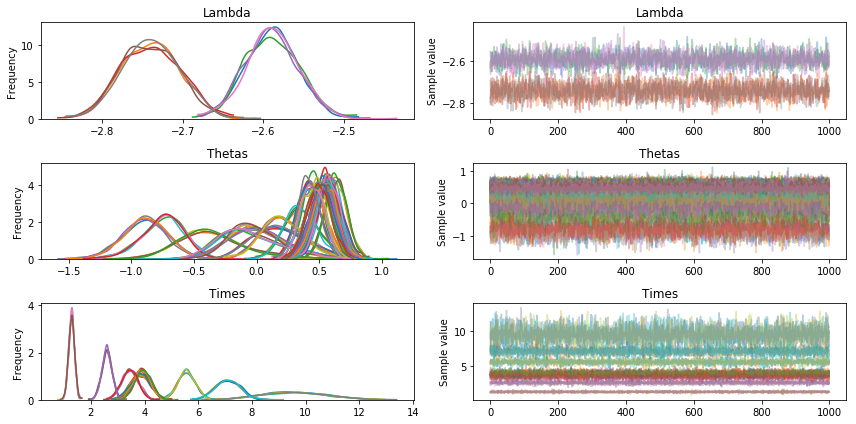

In [338]:
pm.traceplot(samples,varnames=['Lambda','Thetas','Times']);

In [339]:
def construct_output(samples):
    Lambda=samples.get_values('Lambda')[:,0,:]
    Thetas=samples.get_values('Thetas')[:,:,:]
    Times=samples.get_values('Times')[:,0,:]
    return Lambda,Thetas,Times

def single_star_output(samples,star_no):
    Lambda=samples.get_values('Lambda')[:,0,:]
    Thetas=samples.get_values('Thetas')[:,star_no,:]
    Times=samples.get_values('Times')[:,0,star_no].reshape(len(Lambda),1)
    return Lambda,Thetas,Times

In [340]:
Lambda,Thetas,Times=construct_output(samples)

Corner Plot for All Stars

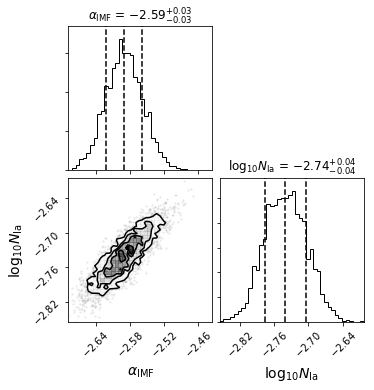

In [341]:
import corner
corner.corner(Lambda,show_titles=True,quantiles=[0.17,0.5,0.83],use_math_text=True,label_kwargs={'fontsize': 14},
              labels=[r'$\alpha_\mathrm{IMF}$',r'$\log_{10}N_\mathrm{Ia}$'],bins=40);

Corner plot for single star (with $1\sigma$ Gaussian smoothing):

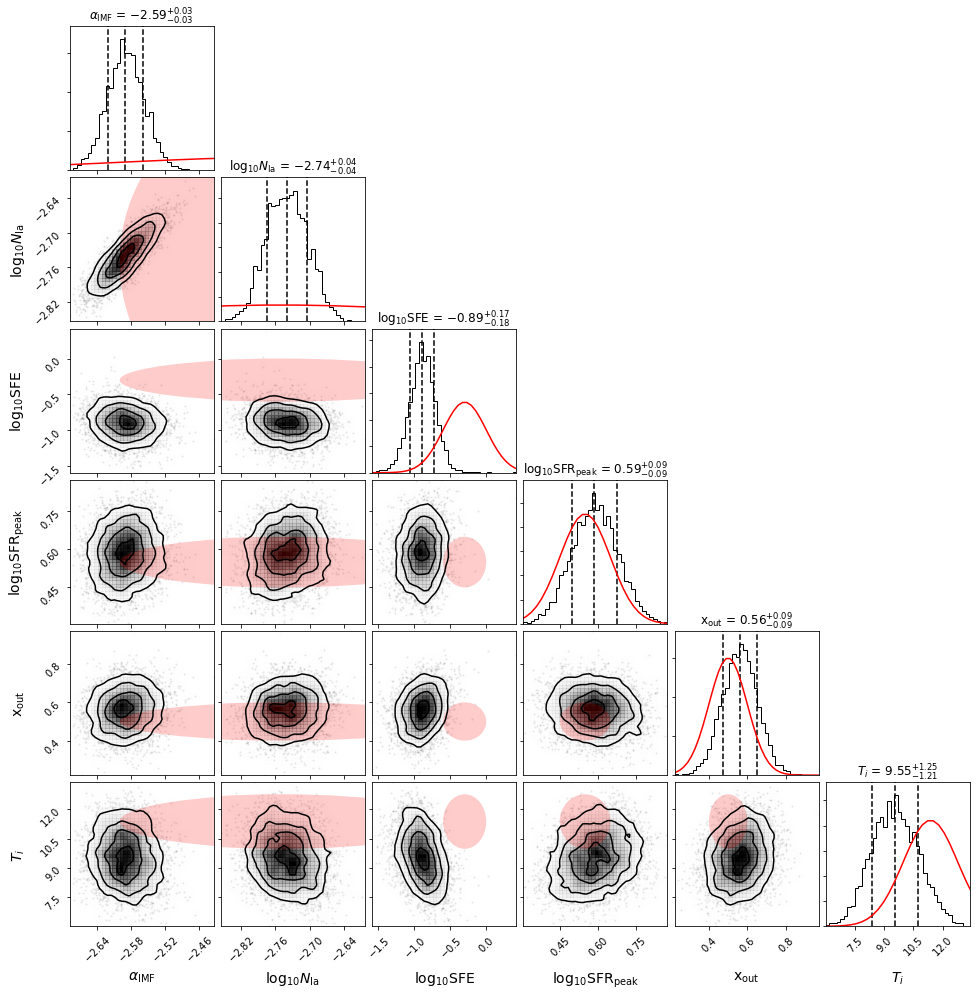

In [342]:
star_index=0
Lambda,Theta1,Times1=single_star_output(samples,star_index)

n_bins=40
names = [r'$\alpha_\mathrm{IMF}$',r'$\log_{10}N_\mathrm{Ia}$',r'$\log_{10}\mathrm{SFE}$',
         r'$\log_{10}\mathrm{SFR}_\mathrm{peak}$',r'$\mathrm{x}_\mathrm{out}$',r'$T_i$']
priors = list(a.p0)+[mu_times[star_index]]
prior_widths = list(np.hstack([Lambda_prior_width,Theta_prior_width]))+[sigma_times[star_index]]
all_dat=np.hstack([Lambda,Theta1,Times1])
figure=corner.corner(all_dat,show_titles=True,quantiles=[0.17,0.5,0.83],use_math_text=True,label_kwargs={'fontsize': 14},
              labels=names,bins=n_bins,scale_hist=False,smooth=1.);

integ=np.zeros(len(all_dat[0]))
for i in range(len(all_dat[0])):
    ct,x,=np.histogram(all_dat[:,i],bins=n_bins)
    integ[i]=np.sum(np.diff(x)*ct)

from matplotlib.patches import Ellipse

# Extract the axes
ndim=len(priors)
axes = np.array(figure.axes).reshape((ndim, ndim))

from scipy.stats import norm

for yi in range(ndim):
    xi=yi
    ax=axes[yi,xi]
    xdata=np.linspace(priors[xi]-10*prior_widths[xi],priors[xi]+10*prior_widths[xi],100)
    ax.plot(xdata,integ[yi]*norm.pdf(xdata,loc=priors[xi],scale=prior_widths[xi]),c='r')

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        el=Ellipse([priors[xi],priors[yi]],2*prior_widths[xi],2*prior_widths[yi])
        ax.add_artist(el)
        el.set_alpha(0.2)
        el.set_facecolor('r')


In [343]:
def plotautocorr(samples,max_lags=30,burn_in=100):
    FS=16
    lambda_samples=samples['Lambda'][:,0,:][burn_in:]
    fig,ax=plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True)
    for l,lam in enumerate(lambda_samples.T):
        ax[l].acorr(lam, detrend=plt.mlab.detrend_mean,maxlags=max_lags)
        ax[l].set_ylabel(r"$\Lambda_{%d}$"%(l+1),fontsize=FS)
        ax[l].set_xlim(0, max_lags)

    ax[1].set_xlabel("Lag",fontsize=FS)
    ax[0].set_title(r"$\Lambda$ Autocorrelation Plot using %d burn-in samples"%burn_in,fontsize=FS);   

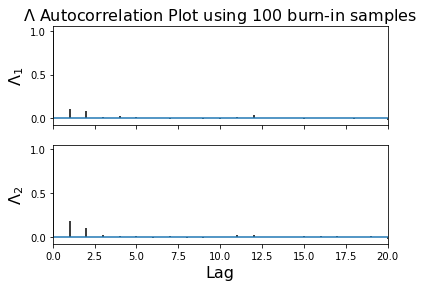

In [344]:
plotautocorr(samples,burn_in=100,max_lags=20);